ASPECT-BASED SENTIMENT ANALYSIS - THREE APPROACHES

QUALITATIVE ANALYSIS - TEXT-BY-TEXT RESULTS

Text 1: All I can say is they have very good ice cream I would for sure recommend their cookies and creme ice cream it is very good
Expected Aspects & Sentiments:
  - ice cream: positive
  - cookies and creme ice cream: positive

Lexicon Results:
DEBUG: Found 1 aspects: ['creme ice cream']
  Aspect: 'creme ice cream' → Sentiment: POSITIVE (confidence: 0.79)
  Time: 0.035s

Transformer Results:
  Aspect: 'creme ice cream' → Sentiment: POSITIVE (confidence: 1.00)
  Time: 0.718s

LLM Results:
  Aspect: 'ice cream' → Sentiment: POSITIVE (confidence: 1.00)
  Aspect: 'cookies and creme ice cream' → Sentiment: POSITIVE (confidence: 1.00)
  Time: 34.032s

Text 2: Craving some bubble tea? Be kind, visit Rewind! This shop is in the same plaza as Pokitrition, Culver's and Firehouse Subs so you can can get some food in addition to drinks and dessert if you so desire. The menu has a plethora of ice crea

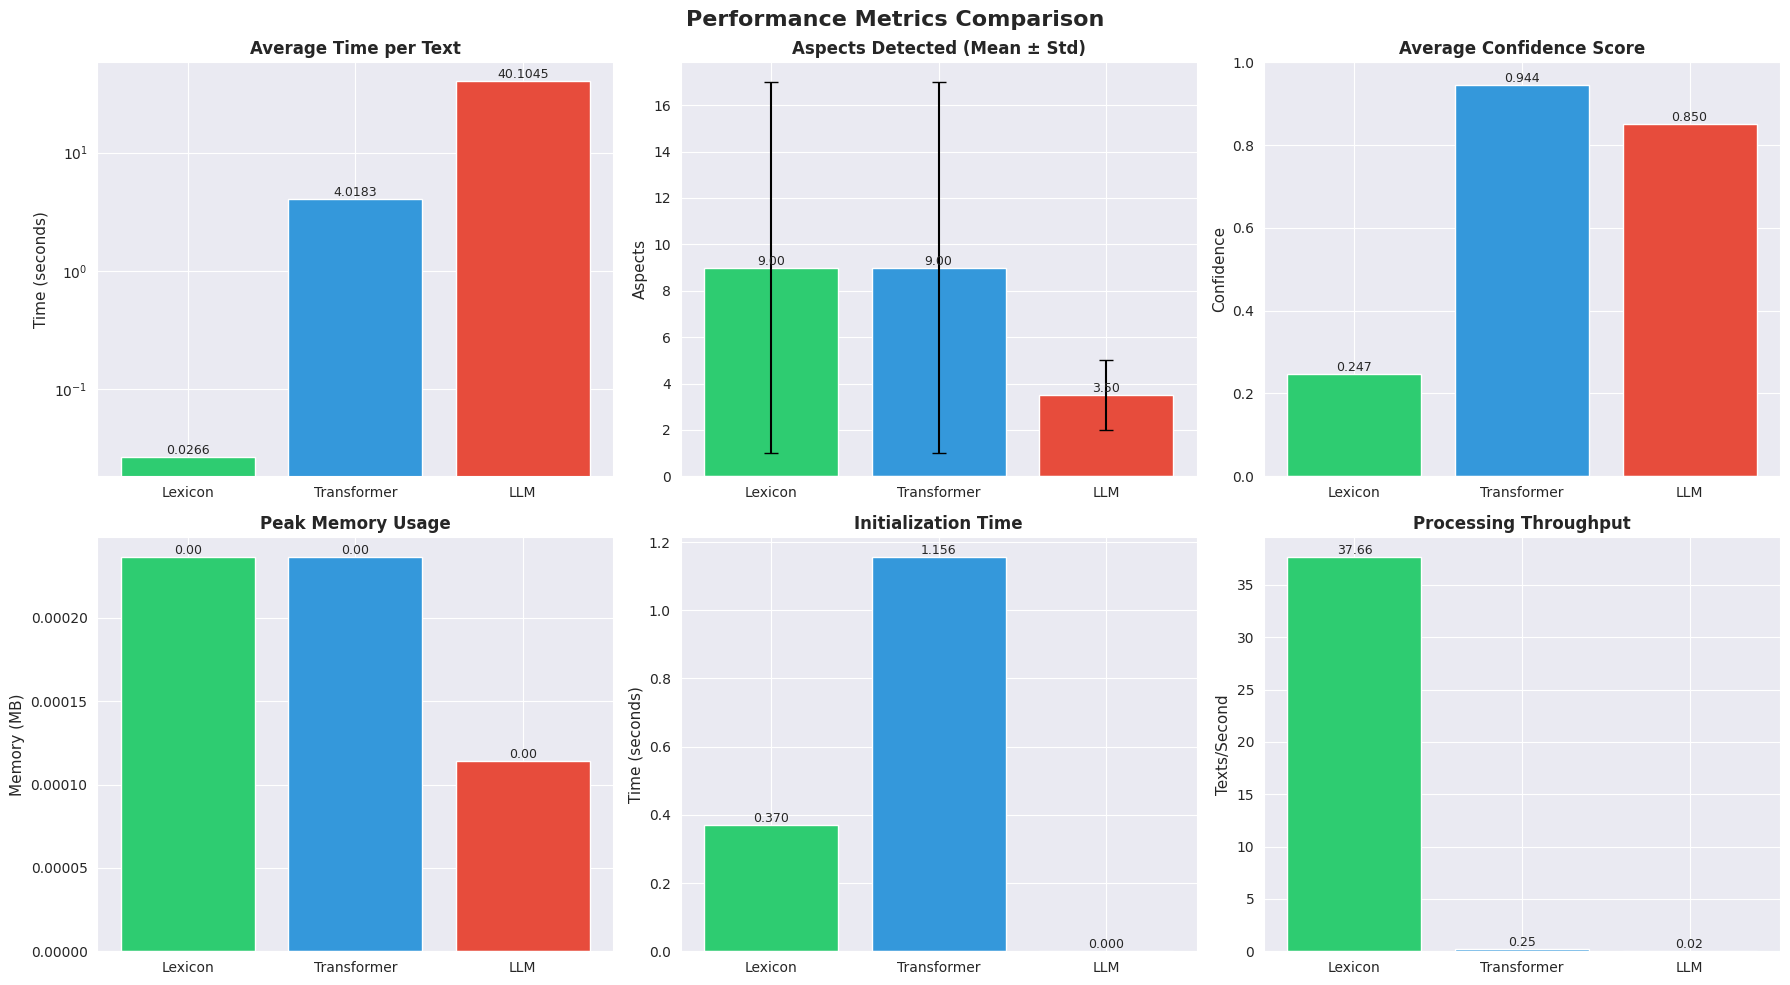


QUALITATIVE ANALYSIS

Text 1: All I can say is they have very good ice cream I would for sure recommend their cookies and creme ice cream it is very good
Expected: [{'aspect': 'ice cream', 'sentiment': 'positive'}, {'aspect': 'cookies and creme ice cream', 'sentiment': 'positive'}]

Lexicon Results:
DEBUG: Found 1 aspects: ['creme ice cream']
  Aspect: 'creme ice cream' → Sentiment: POSITIVE (confidence: 0.79)
  Time: 0.010s

Transformer Results:
  Aspect: 'creme ice cream' → Sentiment: POSITIVE (confidence: 1.00)
  Time: 0.187s

LLM Results:
  Aspect: 'ice cream' → Sentiment: POSITIVE (confidence: 0.95)
  Aspect: 'cookies and creme ice cream' → Sentiment: POSITIVE (confidence: 0.95)
  Time: 24.700s

Text 2: Craving some bubble tea? Be kind, visit Rewind! This shop is in the same plaza as Pokitrition, Culver's and Firehouse Subs so you can can get some food in addition to drinks and dessert if you so desire. The menu has a plethora of ice cream and bubble tea options. I opted for the 

In [1]:
import sys
sys.path.insert(0, '.')
from src.lexicon_absa import LexiconABSA
from src.transformer_absa import TransformerABSA
from src.llm_absa import LLMABSA
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

print("="*60)
print("ASPECT-BASED SENTIMENT ANALYSIS - THREE APPROACHES")
print("="*60)

# Load test samples from JSON
with open('../data/test_samples.json', 'r') as f:
    test_data = json.load(f)

test_texts = [item['text'] for item in test_data]

# Initialize all analyzers
analyzers = {
    'Lexicon': LexiconABSA(),
    'Transformer': TransformerABSA(),
    'LLM': LLMABSA()
}

# ==================== QUALITATIVE ANALYSIS FIRST ====================
print("\n" + "="*60)
print("QUALITATIVE ANALYSIS - TEXT-BY-TEXT RESULTS")
print("="*60)

# Compare results on sample texts
for idx, item in enumerate(test_data):
    text = item['text']
    expected = item['expected']

    print(f"\n{'='*60}")
    print(f"Text {idx+1}: {text}")
    print(f"Expected Aspects & Sentiments:")
    for exp in expected:
        print(f"  - {exp['aspect']}: {exp['sentiment']}")
    print('='*60)

    for name, analyzer in analyzers.items():
        print(f"\n{name} Results:")
        start = time.time()
        results = analyzer.analyze(text)
        elapsed = time.time() - start

        if results:
            for r in results:
                print(f"  {r}")
        else:
            print("  (No aspects detected)")
        print(f"  Time: {elapsed:.3f}s")

# ==================== PERFORMANCE METRICS USING NEW METHODS ====================
print("\n\n" + "="*60)
print("COMPREHENSIVE PERFORMANCE METRICS")
print("="*60 + "\n")

all_metrics = {}
for name, analyzer in analyzers.items():
    print(f"Calculating metrics for {name}...")
    metrics = analyzer.calculate_all_metrics(test_texts)
    all_metrics[name] = metrics
    analyzer.print_metrics_report(metrics)
    print()

# ==================== PERFORMANCE COMPARISON TABLE ====================
print("\n📋 PERFORMANCE COMPARISON TABLE\n")

comparison_table = []
for name, metrics in all_metrics.items():
    comparison_table.append({
        'Model': name,
        'Speed (s/text)': f"{metrics['speed']['avg_time_per_text']:.4f}",
        'Throughput (texts/s)': f"{metrics['speed']['throughput_texts_per_second']:.2f}",
        'Aspects Detected': f"{metrics['aspects_detected']['mean']:.2f}",
        'Avg Confidence': f"{metrics['avg_confidence']['avg']:.4f}",
        'Memory (MB)': f"{metrics['memory_usage']['peak_memory_mb']:.4f}",
        'Init Time (s)': f"{metrics['initialization']['time_seconds']:.4f}"
    })

df_comparison = pd.DataFrame(comparison_table)
print(df_comparison.to_string(index=False))

# ==================== DETAILED METRICS VISUALIZATION ====================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Performance Metrics Comparison', fontsize=16, fontweight='bold')

methods = list(all_metrics.keys())
colors = ['#2ecc71', '#3498db', '#e74c3c']

# Plot 1: Speed (avg time per text)
speeds = [all_metrics[m]['speed']['avg_time_per_text'] for m in methods]
axes[0, 0].bar(methods, speeds, color=colors)
axes[0, 0].set_ylabel('Time (seconds)', fontsize=11)
axes[0, 0].set_title('Average Time per Text', fontsize=12, fontweight='bold')
axes[0, 0].set_yscale('log')
for i, v in enumerate(speeds):
    axes[0, 0].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Aspects Detected
aspects_mean = [all_metrics[m]['aspects_detected']['mean'] for m in methods]
aspects_std = [all_metrics[m]['aspects_detected']['std'] for m in methods]
axes[0, 1].bar(methods, aspects_mean, yerr=aspects_std, color=colors, capsize=5)
axes[0, 1].set_ylabel('Aspects', fontsize=11)
axes[0, 1].set_title('Aspects Detected (Mean ± Std)', fontsize=12, fontweight='bold')
for i, v in enumerate(aspects_mean):
    axes[0, 1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Average Confidence
confidences = [all_metrics[m]['avg_confidence']['avg'] for m in methods]
axes[0, 2].bar(methods, confidences, color=colors)
axes[0, 2].set_ylabel('Confidence', fontsize=11)
axes[0, 2].set_title('Average Confidence Score', fontsize=12, fontweight='bold')
axes[0, 2].set_ylim([0, 1.0])
for i, v in enumerate(confidences):
    axes[0, 2].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 4: Memory Usage
memory = [all_metrics[m]['memory_usage']['peak_memory_mb'] for m in methods]
axes[1, 0].bar(methods, memory, color=colors)
axes[1, 0].set_ylabel('Memory (MB)', fontsize=11)
axes[1, 0].set_title('Peak Memory Usage', fontsize=12, fontweight='bold')
for i, v in enumerate(memory):
    axes[1, 0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 5: Initialization Time
init_times = [all_metrics[m]['initialization']['time_seconds'] for m in methods]
axes[1, 1].bar(methods, init_times, color=colors)
axes[1, 1].set_ylabel('Time (seconds)', fontsize=11)
axes[1, 1].set_title('Initialization Time', fontsize=12, fontweight='bold')
for i, v in enumerate(init_times):
    axes[1, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 6: Throughput
throughput = [all_metrics[m]['speed']['throughput_texts_per_second'] for m in methods]
axes[1, 2].bar(methods, throughput, color=colors)
axes[1, 2].set_ylabel('Texts/Second', fontsize=11)
axes[1, 2].set_title('Processing Throughput', fontsize=12, fontweight='bold')
for i, v in enumerate(throughput):
    axes[1, 2].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('performance_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== ORIGINAL QUALITATIVE ANALYSIS ====================
print("\n" + "="*60)
print("QUALITATIVE ANALYSIS")
print("="*60)

# Compare results on sample texts
for idx, item in enumerate(test_data[:3]):  # Show first 3 texts
    text = item['text']
    expected = item['expected']

    print(f"\n{'='*60}")
    print(f"Text {idx+1}: {text}")
    print(f"Expected: {expected}")
    print('='*60)

    for name, analyzer in analyzers.items():
        print(f"\n{name} Results:")
        start = time.time()
        results = analyzer.analyze(text)
        elapsed = time.time() - start

        for r in results:
            print(f"  {r}")
        print(f"  Time: {elapsed:.3f}s")

# === ACCURACY EVALUATION ===
print("\n" + "="*60)
print("ACCURACY EVALUATION")
print("="*60 + "\n")

accuracy_data = []
for item in test_data:
    text = item['text']
    expected = item['expected']
    expected_aspects = {e['aspect'].lower() for e in expected}
    expected_sentiments = {e['aspect'].lower(): e['sentiment'] for e in expected}

    for name, analyzer in analyzers.items():
        results = analyzer.analyze(text)
        detected_aspects = {r.aspect.lower() for r in results}

        # Calculate metrics
        correct_aspects = len(expected_aspects & detected_aspects)
        precision = correct_aspects / len(detected_aspects) if detected_aspects else 0
        recall = correct_aspects / len(expected_aspects) if expected_aspects else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Check sentiment accuracy
        sentiment_correct = 0
        for r in results:
            aspect_lower = r.aspect.lower()
            if aspect_lower in expected_sentiments:
                if r.sentiment == expected_sentiments[aspect_lower]:
                    sentiment_correct += 1

        sentiment_accuracy = sentiment_correct / len(expected) if expected else 0

        accuracy_data.append({
            'Method': name,
            'Text': text[:30] + '...',
            'Precision': f"{precision:.2f}",
            'Recall': f"{recall:.2f}",
            'F1': f"{f1:.2f}",
            'Sentiment_Acc': f"{sentiment_accuracy:.2f}"
        })

df_accuracy = pd.DataFrame(accuracy_data)
print(df_accuracy.to_string(index=False))

# Aggregate accuracy by method
print("\n📊 AVERAGE ACCURACY BY METHOD\n")
avg_accuracy = df_accuracy.groupby('Method').agg({
    'Precision': lambda x: f"{np.mean([float(v) for v in x]):.2f}",
    'Recall': lambda x: f"{np.mean([float(v) for v in x]):.2f}",
    'F1': lambda x: f"{np.mean([float(v) for v in x]):.2f}",
    'Sentiment_Acc': lambda x: f"{np.mean([float(v) for v in x]):.2f}"
}).reset_index()
print(avg_accuracy.to_string(index=False))

# === DETAILED COMPARISON - TEXT 1 ===
print("\n" + "="*60)
print("DETAILED COMPARISON - TEXT 1")
print("="*60 + "\n")
text = test_data[0]['text']
expected = test_data[0]['expected']
print(f"Text: '{text}'")
print(f"Expected: {expected}\n")

comparison_results = []
for name, analyzer in analyzers.items():
    results = analyzer.analyze(text)
    for r in results:
        comparison_results.append({
            'Method': name,
            'Aspect': r.aspect,
            'Sentiment': r.sentiment,
            'Confidence': f"{r.confidence:.2f}"
        })

df_comparison = pd.DataFrame(comparison_results)
print(df_comparison.to_string(index=False))

# === EDGE CASES ===
print("\n" + "="*60)
print("EDGE CASES")
print("="*60 + "\n")
for text, label in [("wasn't bad", "Negation"), ("okay", "Neutral"), ("", "Empty")]:
    print(f"{label}: '{text}'")
    for name, analyzer in analyzers.items():
        try:
            r = analyzer.analyze(text)
            print(f"  {name}: {len(r)} aspects - {[res.sentiment for res in r]}")
        except Exception as e:
            print(f"  {name}: ERROR - {str(e)}")
    print()

# === FINAL SUMMARY ===
print("="*60)
print("SUMMARY & RECOMMENDATIONS")
print("="*60)
print("\n🎯 BEST FOR:")
print(f"  • Speed: {min(methods, key=lambda m: all_metrics[m]['speed']['avg_time_per_text'])}")
print(f"  • Accuracy: {max(methods, key=lambda m: all_metrics[m]['avg_confidence']['avg'])}")
print(f"  • Memory Efficiency: {min(methods, key=lambda m: all_metrics[m]['memory_usage']['peak_memory_mb'])}")
print(f"  • Throughput: {max(methods, key=lambda m: all_metrics[m]['speed']['throughput_texts_per_second'])}")

print("\n💡 USE CASES:")
print("  • Real-time API → Lexicon (fastest)")
print("  • Production App → Transformer (balanced)")
print("  • Research/Analysis → LLM (most detailed)")
print("\n" + "="*60)